# Natural Language Processing - Text Summarization

### Ziv Attias


In [1]:
import os

import pandas as pd
from datasets import load_dataset

# Remote dataset load:
# Use this when evaluating my work!
# dataset = load_dataset("cnn_dailymail", "3.0.0")

# Local dataset load:
BASE_DATASET_PATH = os.path.join("data", "cnn_dailymail")

ds = load_dataset(
    "parquet",
    data_files={
        "train": [
            os.path.join(BASE_DATASET_PATH, "train-00000-of-00003.parquet"),
            os.path.join(BASE_DATASET_PATH, "train-00001-of-00003.parquet"),
            os.path.join(BASE_DATASET_PATH, "train-00002-of-00003.parquet"),
        ],
        "test": os.path.join(BASE_DATASET_PATH, "test-00000-of-00001.parquet"),
        "validation": os.path.join(
            BASE_DATASET_PATH, "validation-00000-of-00001.parquet"
        ),
    },
)

df = ds["train"].to_pandas()
df = df.head(1000)
df.head()

/Users/zivattias/.local/share/virtualenvs/nlp_project-oDy93Rcp/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zivattias/.local/share/virtualenvs/nlp_project-oDy93Rcp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [8]:
import nltk

# Download necessary resources from nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")


def preprocess_text(text):
    # Tokenize text
    tokens = nltk.tokenize.word_tokenize(text)
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    # Remove stop words (optional)
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to /Users/zivattias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zivattias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zivattias/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
###====== Part 2.1 =====================
df["article_len"] = df["article"].apply(len)
df["highlights_len"] = df["highlights"].apply(len)

In [10]:
df.head()

,article,highlights,id,article_len,highlights_len
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,2527,217
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,4051,281
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,3940,224
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,2620,185
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,5764,273


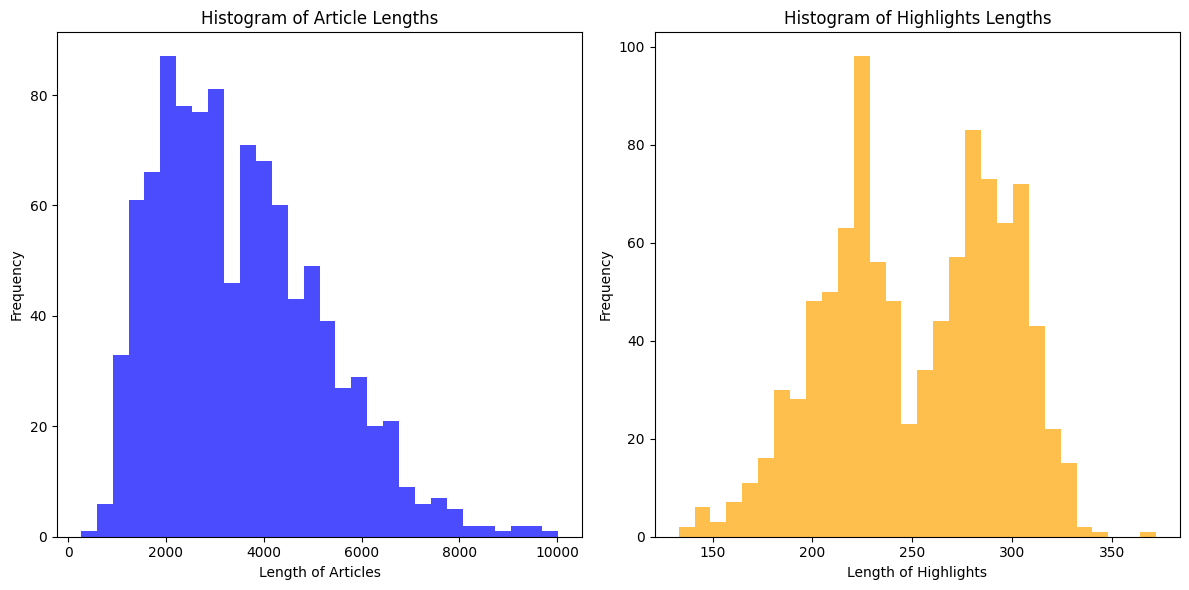

In [11]:
import matplotlib.pyplot as plt


###====== Part 2.2 =====================
def plot_histograms(df):

    plt.figure(figsize=(12, 6))

    # Histogram for article lengths
    plt.subplot(1, 2, 1)
    plt.hist(df["article_len"], bins=30, color="blue", alpha=0.7)
    plt.title("Histogram of Article Lengths")
    plt.xlabel("Length of Articles")
    plt.ylabel("Frequency")

    # Histogram for highlights lengths
    plt.subplot(1, 2, 2)
    plt.hist(df["highlights_len"], bins=30, color="orange", alpha=0.7)
    plt.title("Histogram of Highlights Lengths")
    plt.xlabel("Length of Highlights")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


plot_histograms(df)

Text(0.5, 1.0, 'Rouge-2 score distribution on ground truth')

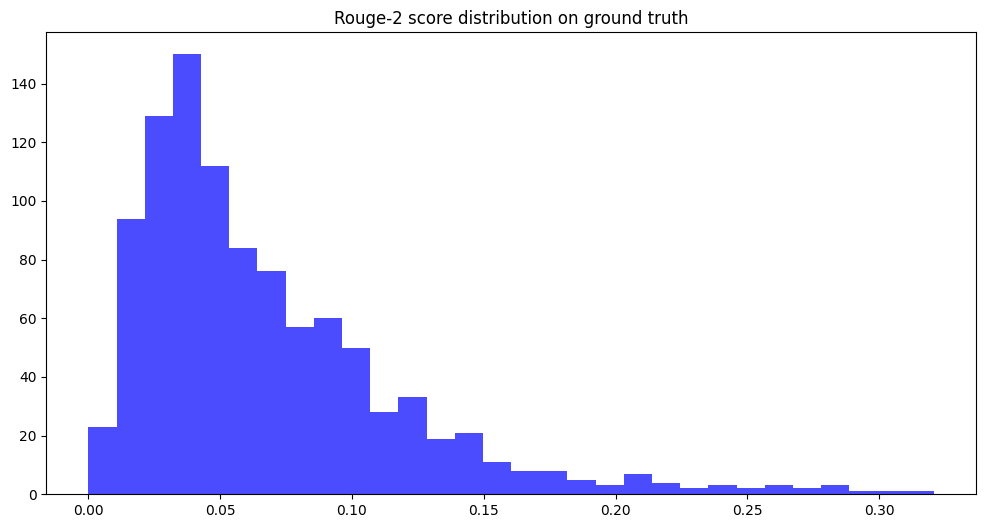

In [31]:
###======Part 2.3 ================
def ngrams(text, n):
    # Preprocess the text first
    processed_text = preprocess_text(text)
    words = processed_text.split()
    return set(zip(*[words[i:] for i in range(n)]))


def rouge_n(reference, candidate, n):
    """Calculate the Rouge-N score (precision, recall, and F1) for a single reference and candidate pair."""

    reference_ngrams = ngrams(reference, n)
    candidate_ngrams = ngrams(candidate, n)

    overlap = reference_ngrams.intersection(candidate_ngrams)
    recall = len(overlap) / len(reference_ngrams) if len(reference_ngrams) > 0 else 0.0
    precision = (
        len(overlap) / len(candidate_ngrams) if len(candidate_ngrams) > 0 else 0.0
    )

    if recall + precision > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0

    return f1_score


###=========== 2.3 ================

# Example of calculating Rouge-1 and Rouge-2 for a dataframe
df["rouge_1"] = df.apply(
    lambda row: rouge_n(row["highlights"], row["article"], 1), axis=1
)
df["rouge_2"] = df.apply(
    lambda row: rouge_n(row["highlights"], row["article"], 2), axis=1
)

plt.figure(figsize=(12, 6))
plt.hist(df["rouge_2"], bins=30, color="blue", alpha=0.7)
plt.title("Rouge-2 score distribution on ground truth")

In [32]:
df.head()

,article,highlights,id,article_len,highlights_len,rouge_1,rouge_2,summary
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,2527,217,0.199095,0.155642,he says he has no plans to fritter his cash aw...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,4051,281,0.168582,0.050420,inmates with most severe mental illnesses are ...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,3940,224,0.123457,0.040230,"survivor: ""i probably had a 30-, 35-foot free ..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,2620,185,0.157068,0.039683,"new: ""none appeared worrisome,"" white house sp..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,5764,273,0.102102,0.026565,"new: ""your admitted conduct was not only illeg..."


In [33]:
# Rouge 2 Lowest
print("Rouge 2 Lowest", df["rouge_2"].min())
min_rouge_2_index = df["rouge_2"].argmin()
print("Index of article with lowest Rouge-2 score:", min_rouge_2_index)
print("========================\n")
print("Article with lowest Rouge-2 score:", df.iloc[min_rouge_2_index]["article"])
print("========================\n")
print(
    "Highlights with lowest Rouge-2 score:",
    df.iloc[min_rouge_2_index]["highlights"],
    end="\n\n\n\n",
)

# Rogue 2 Highest
print("Rouge 2 Highest", df["rouge_2"].max())
max_rouge_2_index = df["rouge_2"].argmax()
print("Index of article with highest Rouge-2 score:", max_rouge_2_index)
print("========================\n")
print("Article with highest Rouge-2 score:", df.iloc[max_rouge_2_index]["article"])
print("========================\n")
print(
    "Highlights with highest Rouge-2 score:",
    df.iloc[max_rouge_2_index]["highlights"],
    end="\n\n\n\n",
)


# Rouge 1 Lowest
print("Rouge 1 Lowest", df["rouge_1"].min())
min_rouge_1_index = df["rouge_1"].argmin()
print("Index of article with lowest Rouge-1 score:", min_rouge_1_index)
print("========================\n")
print("Article with lowest Rouge-1 score:", df.iloc[min_rouge_1_index]["article"])
print("========================\n")
print(
    "Highlights with lowest Rouge-1 score:",
    df.iloc[min_rouge_1_index]["highlights"],
    end="\n\n\n\n",
)

# Rouge 1 Highest
print("Rouge 1 Highest", df["rouge_1"].max())
max_rouge_1_index = df["rouge_1"].argmax()
print("Index of article with lowest Rouge-1 score:", max_rouge_1_index)
print("========================\n")
print("Article with highest Rouge-1 score:", df.iloc[max_rouge_1_index]["article"])
print("========================\n")
print(
    "Highlights with highest Rouge-1 score:", df.iloc[max_rouge_1_index]["highlights"]
)

Rouge 2 Lowest 0.0
Index of article with lowest Rouge-2 score: 70

Article with lowest Rouge-2 score: (CNN) -- The company was founded in 1985 by seven communications industry veterans -- Franklin Antonio, Adelia Coffman, Andrew Cohen, Klein Gilhousen, Irwin Jacobs, Andrew Viterbi and Harvey White. One of Qualcomm's first products was OmniTRACS, introduced in 1988, which is currently the largest satellite-based commercial mobile system for the transportation industry. Today, Qualcomm's patent portfolio includes approximately 6,100 United States patents and patent applications for CDMA and related technologies. More than 130 telecommunications equipment manufacturers worldwide have licensed QUALCOMM's essential CDMA patents. Qualcomm is among the members of the S&P 500 Index, Fortune 500, and a winner of the U.S. Department of Labor's" Secretary of Labor's Opportunity Award." The company has been listed among Fortune's "100 Best Companies to Work For in America" for nine years in a row 

In [35]:
from transformers import pipeline

###=========== 2.4 ================
# Initialize the summarization pipeline
summarizer = pipeline(
    "summarization", model=os.path.join("model", "text-summarization")
)


def summarize_text(text):
    # Summarizing the text using the pipeline
    summary = summarizer(text, max_length=20, min_length=5, do_sample=False)
    print("-")
    return summary[0]["summary_text"]


df["summary"] = df["article"].head(10).apply(summarize_text)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


-
-
-
-
-
-
-
-
-
-


In [39]:
# Calculate the rouge-2 score of the first 10 entries

first_ten_entries_df = df.head(10)


first_ten_entries_df["rouge_2_pipeline"] = first_ten_entries_df.apply(
    lambda row: rouge_n(row["highlights"], row["summary"], 2), axis=1
)

compact_df = first_ten_entries_df[
    ["highlights", "rouge_1", "rouge_2", "rouge_2_pipeline", "summary"]
]

compact_df

/var/folders/6j/s5svmgq938g06rxvr91485zw0000gn/T/ipykernel_11061/554722502.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_ten_entries_df["rouge_2_pipeline"] = first_ten_entries_df.apply(


,highlights,rouge_1,rouge_2,rouge_2_pipeline,summary
0,Harry Potter star Daniel Radcliffe gets £20M f...,0.199095,0.155642,0.266667,he says he has no plans to fritter his cash aw...
1,Mentally ill inmates in Miami are housed on th...,0.168582,0.050420,0.000000,inmates with most severe mental illnesses are ...
2,"NEW: ""I thought I was going to die,"" driver sa...",0.123457,0.040230,0.153846,"survivor: ""i probably had a 30-, 35-foot free ..."
3,"Five small polyps found during procedure; ""non...",0.157068,0.039683,0.074074,"new: ""none appeared worrisome,"" white house sp..."
4,"NEW: NFL chief, Atlanta Falcons owner critical...",0.102102,0.026565,0.000000,"new: ""your admitted conduct was not only illeg..."
5,"Parents beam with pride, can't stop from smili...",0.106383,0.026525,0.000000,new: youssif's parents say they know it's goin...
6,"Aid workers: Violence, increased cost of livin...",0.116883,0.028571,0.054054,"women are driven to prostitution to ""save my c..."
7,Tomas Medina Caracas was a fugitive from a U.S...,0.279070,0.132075,0.258065,fugitive from drug trafficking indictment kill...
8,"President Bush says Tony Snow ""will battle can...",0.158730,0.057971,0.080000,white house press secretary to step down from ...
9,Empty anti-tank weapon turns up in front of Ne...,0.152778,0.043011,0.000000,the 20-year-old AT4 anti-tank rocket launcher ...
